# Stimulus-Evoked Activity under *in vivo*-like conditions

In [1]:
import numpy as np
from scipy.stats import sem

from cell_template import BRANCH_COLORS
from parallel import Parallel

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

--No graphics will be displayed.


# Protocol Description

- synapses splitted in excitatory (80%) and inhibitory (20%) categories
- background excitatory+inhibitory synaptic events at a given frequency (events through Poisson process)
- stimulus events: a set of synaptic events randomly picked within the excitatory population
- stimulus stength variable: **$n_{syn}$** the number of randomly picked synapses
- stimulus temporal width: **$\sigma$** the width of the gaussian distribution from which synaptic events are drawn
- simulations on a per branch basis -- considering only the synapses of a given branch -- performing simulations on each branch
- firing response in Hz measured in [0,100]ms window following the stimulus

### Functions to Load and Analyze the Simulation Data

In [5]:
def load_params_from(sim):
    p = {}
    for k in ['dt', 'nStimRepeat', 'ISI', 't0']:
        p[k] = sim.fetch_quantity_on_grid(k, dtype=float, return_last=True) 
    p['nCluster'] = sim.fetch_quantity_on_grid('nCluster', dtype=object, return_last=True)
    return p

def show_Vm_trace(sim, 
                  loc='soma',
                  iBranch=0, 
                  varied_key = 'with_NMDA',
                  plot = {'with-NMDA':{'varied_key':True,
                                       'color':'tab:orange',
                                       'lw':1.0},
                          'without':{'varied_key':False,
                                    'color':'tab:grey',
                                    'lw':0.5}},
                  zoom=None):
    
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    params = dict(iBranch=iBranch)

    fig, ax = pt.figure(figsize=(2.5,2), left=0.2, bottom=0.5)

    Vms = {}
    for label in plot:
        params[varied_key] = plot[label]['varied_key']
        Vm = sim.get('Vm_%s' % loc, params)[0]
        t = np.arange(len(Vm))*p['dt']
        if zoom is not None:
            Vm = Vm[(t>zoom[0]) & (t<zoom[1])]
            t = t[(t>zoom[0]) & (t<zoom[1])]
        else:
            zoom=[t[0], t[-1]]
        ax.plot(t, Vm, label=label, color=plot[label]['color'], lw=plot[label]['lw'])

    for r in range(int(p['nStimRepeat'])):
        for c, nC in enumerate(p['nCluster']):
            tstart = p['t0']+r*len(p['nCluster'])*p['ISI']+c*p['ISI']
            if (tstart>zoom[0]) and (tstart<zoom[1]):
                pt.arrow(ax, [tstart, 0, 0, -10],
                         head_width=4, head_length=5, width=0.1)
                pt.annotate(ax, 'n$_{syn}$=%i' % nC, (tstart, 5), 
                            rotation=90, xycoords='data', fontsize=6, ha='right')
            
    ax.axis('off')
    ax.legend(loc=(1,0.4), frameon=False)
    pt.draw_bar_scales(ax, Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
    return fig

def extract_trials(sim, 
                  loc='soma',
                  varied_key = 'with_NMDA',
                  true_false_labels=['with-NMDA', 'without'],
                  pre=-30, post=150):
    """
    returns elements of shape:
               VMs     (nBranch, nStims, nStimRepeat, nTimeSamples)
               SPIKES  (nBranch, nStims, nStimRepeat, nTimeSamples)
    """
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    nBranch = len(np.unique(sim.iBranch))
    nStims = len(p['nCluster'])
    VMs, SPIKEs, RATEs = {}, {}, {}
    
    for l, label in enumerate(true_false_labels):
        VMs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)))
        SPIKEs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)), dtype=int)
        RATEs[label] = np.zeros((nBranch, nStims, int(p['nStimRepeat']), len(T)), dtype=float)
        
        for iBranch in np.unique(sim.iBranch):
            
            params = {varied_key:(label==true_false_labels[0]),
                      'iBranch':iBranch}

            Vm = sim.get('Vm_%s' % loc, params)[0]
            
            _, VMs[label][iBranch, :, :, :], SPIKEs[label][iBranch, :, :, :] = \
                    trial_alignement(Vm, p, pre=pre, post=post)
            RATEs[label][iBranch, :, :, :] = 1e3*SPIKEs[label][iBranch, :, :, :]/p['dt']
            
    return T, VMs, SPIKEs, RATEs
    
def trial_alignement(Vm, p, 
                     spike_threshold=-20,
                     pre=-30, post=150):
    
    t = np.arange(len(Vm))*p['dt']
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    VMs = np.zeros((len(p['nCluster']), int(p['nStimRepeat']), len(T)))
    SPIKEs = np.zeros((len(p['nCluster']), int(p['nStimRepeat']), len(T)), dtype=int)
    for r in range(int(p['nStimRepeat'])):
        for c, nC in enumerate(p['nCluster']):
            tstart = p['t0']+r*len(p['nCluster'])*p['ISI']+c*p['ISI']
            cond = t>=(tstart+T[0])
            VMs[c,r,:] = Vm[cond][:len(T)]
            # count spikes
            iSpks =np.argwhere((VMs[c,r,:][1:]>=spike_threshold) & (VMs[c,r,:][:-1]<spike_threshold))
            SPIKEs[c,r,1:][iSpks] = 1
        
    return T, VMs, SPIKEs

# Basket Cell

### Demo Simulation

```
python stim_on_background.py -c Basket --nCluster 20 40 60 80 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 10 --test_uniform --nsyn_width_scan
```

In [6]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_NsynWidthScan_Basket.zip')
sim.load()
t0 = 100
fig = show_Vm_trace(sim, iBranch=2, zoom=[t0,t0+3000],
                    varied_key = 'from_uniform',
              plot = {'real':{'varied_key':False,
                              'color':'tab:red',
                                       'lw':1.0},
                      'uniform':{'varied_key':True,
                                 'color':'tab:grey',
                                 'lw':0.5}})
#fig.savefig('../../figures/detailed_model/raw-stim-with-bg-Basket.eps')
#fig.savefig('../../figures/detailed_model/raw-stim-with-bg-Basket.svg')

KeyError: "There is no item named 'scan.npy' in the archive"

## Full Simulations

```
python stim_on_background.py -c Basket --nCluster 0 5 10 15 20 25 30 35 40 45 50 55 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 100 --test_uniform --suffix Full --ISI 400 
```

In [3]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simFull_Basket.zip')
sim.load()

In [4]:
T, VMs, SPIKEs, RATEs = extract_trials(sim,
                                       loc='soma',
                                       varied_key = 'from_uniform',
                                       true_false_labels=['uniform', 'real'],
                                       pre=0, post=100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


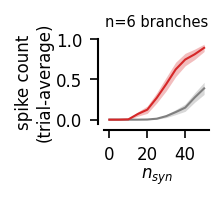

In [159]:
fig, ax = pt.figure(figsize=(0.9,0.9))
for l, label, color in zip(range(2), ['uniform', 'real'], ['tab:grey', 'tab:red']):
    spike_count = SPIKEs[label][:,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
    pt.plot(np.unique(sim.nCluster)[0], np.mean(spike_count, axis=0),
            sy=sem(spike_count, axis=0),
            color=color, ax=ax)
    pt.annotate()
pt.set_plot(ax, xlabel='$n_{syn}$', yticks=[0,0.5,1],
            xticks=[0, 20, 40], #xticks_labels=['5', '', '25', '', '45'],
            ylabel='spike count\n(trial-average)')
ax.set_title('n=6 branches', fontsize=7)
fig.savefig('../../figures/detailed_model/spiking-responses-Basket.eps')
fig.savefig('../../figures/detailed_model/spiking-responses-Basket.svg')

# Martinotti Cell

### Demo Simulation

```
python stim_on_background.py -c Martinotti --nCluster 5 15 25 35 45 --bgStimFreq 5e-4 --bgFreqInhFactor 1 --nStimRepeat 10 --test_NMDA --suffix Demo
```

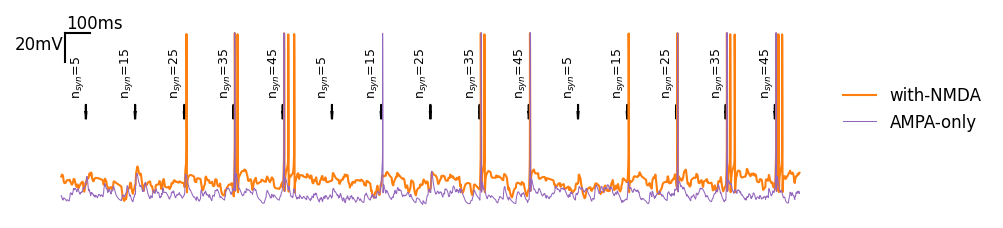

In [8]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simDemo_Martinotti.zip')
sim.load()
t0 = 3100
fig = show_Vm_trace(sim, iBranch=1, zoom=[t0,t0+3000],
              varied_key = 'with_NMDA',
              plot = {'with-NMDA':{'varied_key':True,
                                       'color':'tab:orange',
                                       'lw':1.0},
                      'AMPA-only':{'varied_key':False,
                                   'color':'tab:purple',
                                   'lw':0.5}})
fig.savefig('../../figures/detailed_model/raw-stim-with-bg-Martinotti.eps')
fig.savefig('../../figures/detailed_model/raw-stim-with-bg-Martinotti.svg')

## Full Simulation

```
python stim_on_background.py -c Martinotti --nCluster 0 5 10 15 20 25 30 35 40 45 --bgStimFreq 5e-4 --bgFreqInhFactor 1 --nStimRepeat 100 --test_NMDA --suffix Full --ISI 400
```

In [6]:
sim = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simFull_Martinotti.zip')
sim.load()
T, VMs, SPIKEs, RATEs = extract_trials(sim,
                                       loc='soma',
                                       varied_key = 'with_NMDA',
                                       true_false_labels=['with-NMDA', 'without'],
                                       pre=0, post=100)

In [7]:
# real vs uniform in Martinotti cell
sim2 = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simFull2_Martinotti.zip')
sim2.load()
_, _, SPIKEs2, _ = extract_trials(sim2,
                                  loc='soma',
                                  varied_key = 'from_uniform',
                                  true_false_labels=['uniform', 'real'],
                                  pre=0, post=100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


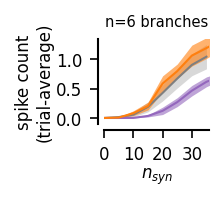

In [8]:
fig, ax = pt.figure(figsize=(0.9,0.9))
xlim = [0,36]
# adding uniform case
spike_count = SPIKEs2['uniform'][:,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
pt.plot(np.array(np.unique(sim2.nCluster)[0]), np.mean(spike_count, axis=0), sy=sem(spike_count, axis=0),
        color='tab:grey', ax=ax, no_set=True)
# now with and without NMDA
x, MEANS = np.array(np.unique(sim.nCluster)[0]), []
for l, label, color in zip(range(2), ['without', 'with-NMDA'], ['tab:purple', 'tab:orange']):
    spike_count = SPIKEs[label][:,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
    MEANS.append(np.mean(spike_count, axis=0)[x<xlim[1]])
    pt.plot(x, np.mean(spike_count, axis=0),
            sy=sem(spike_count, axis=0),
            color=color, ax=ax, alpha_std=.6, no_set=True)
pt.set_plot(ax, xlabel='$n_{syn}$', xlim=xlim, ylim=[-0.1,1.35],
            xticks=[0, 10, 20, 30],
            ylabel='spike count\n(trial-average)')
x = x[x<xlim[1]]
ax.set_title('n=6 branches', fontsize=7)
fig.savefig('../../figures/detailed_model/spiking-responses-Martinotti.eps')
fig.savefig('../../figures/detailed_model/spiking-responses-Martinotti.svg')

## Prediction of In-Vivo Data from those Response Curves

We interpret $N_{syn}$ as different levels of visual stimulation contrast and/or orientation (prefered vs orthogonal) for a single cell

### Contrast Sensitivity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


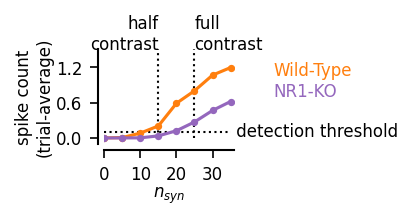

In [14]:
fig, ax = pt.figure(top=4, right=10)
xHalf, xFull = 15, 25
iHalf, iHalf = np.flatnonzero(x==xHalf)[0], np.flatnonzero(x==xFull)[0]
respThreshold = 0.1
ax.plot(x, 0*x+respThreshold, ':', color='k')
ax.annotate(' detection threshold', (x[-1], respThreshold), xycoords='data', va='center')
ax.plot([xHalf,xHalf], [0,1.5], ':', color='k')
ax.annotate('half\ncontrast', (xHalf,1.5), xycoords='data', ha='right')
ax.plot([xFull, xFull], [0,1.5], ':', color='k')
ax.annotate('full\ncontrast', (xFull,1.5), xycoords='data', ha='left')
ax.plot(x, MEANS[1], 'o-', color='tab:orange', lw=1.5)
ax.plot(x, MEANS[0], 'o-', color='tab:purple', lw=1.5)
ax.annotate('Wild-Type\n', (1.3,.5), xycoords='axes fraction', color='tab:orange')
ax.annotate('NR1-KO', (1.3,.5), xycoords='axes fraction', color='tab:purple')
pt.set_plot(ax, xlabel='$n_{syn}$', xlim=xlim, ylim=[-0.1,1.5],
            xticks=[0, 10, 20, 30],
            ylabel='spike count\n(trial-average)')
"""
inset = pt.inset(ax, (2.7,0.2,0.35,0.7))
inset.bar([0], [(MEANS[1][iPref]-MEANS[1][iOrth])/MEANS[1][iPref]], color='tab:orange')
inset.bar([1], [(MEANS[0][iPref]-MEANS[0][iOrth])/MEANS[0][iPref]], color='tab:grey')
inset.set_title('Orientation\nSelectivity\nIndex')
pt.set_plot(inset, ylabel='OSI', xticks=[0,1], xticks_labels=['WT  ', '    KO'])
"""
fig.savefig('../../figures/detailed_model/in-vivo-pred-Contrast-Sensitivity.eps')
fig.savefig('../../figures/detailed_model/in-vivo-pred-Contrast-Sensitivity.svg')

### Orientation Selectivity

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


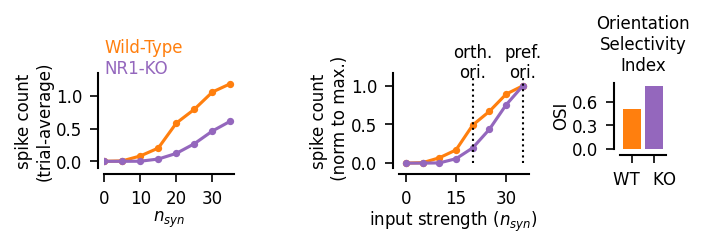

In [12]:
fig, AX = pt.figure(axes=(2,1), wspace=2, top=4, right=10)
xOrth, xPref = 20, 35
iOrth, iPref = np.flatnonzero(x==xOrth)[0], np.flatnonzero(x==xPref)[0]
AX[0].plot(x, MEANS[1], 'o-', color='tab:orange', lw=1.5)
AX[0].plot(x, MEANS[0], 'o-', color='tab:purple', lw=1.5)
AX[0].annotate('Wild-Type\n', (0,1), xycoords='axes fraction', color='tab:orange')
AX[0].annotate('NR1-KO', (0,1), xycoords='axes fraction', color='tab:purple')
pt.set_plot(AX[0], xlabel='$n_{syn}$', xlim=xlim, ylim=[-0.1,1.35],
            xticks=[0, 10, 20, 30],
            ylabel='spike count\n(trial-average)')
AX[1].plot(x, MEANS[1]/np.max(MEANS[1]), 'o-', color='tab:orange', lw=1.5)
AX[1].plot(x, MEANS[0]/np.max(MEANS[0]), 'o-', color='tab:purple', lw=1.5)
AX[1].plot([xPref,xPref], [0,1.1], ':', color='k')
AX[1].annotate('pref.\nori.', (35,1.1), xycoords='data', ha='center')
AX[1].plot([xOrth,xOrth], [0,1.1], ':', color='k')
AX[1].annotate('orth.\nori.', (20,1.1), xycoords='data', ha='center')
pt.set_plot(AX[1], 
            xlabel='input strength ($n_{syn}$)     ',
            ylabel='spike count\n (norm to max.)')
inset = pt.inset(AX[1], (1.7,0.2,0.35,0.7))
inset.bar([0], [(MEANS[1][iPref]-MEANS[1][iOrth])/MEANS[1][iPref]], color='tab:orange')
inset.bar([1], [(MEANS[0][iPref]-MEANS[0][iOrth])/MEANS[0][iPref]], color='tab:purple')
inset.set_title('Orientation\nSelectivity\nIndex')
pt.set_plot(inset, ylabel='OSI', xticks=[0,1], xticks_labels=['WT  ', '    KO'])
fig.savefig('../../figures/detailed_model/in-vivo-pred-Orientation-Tuning.eps')
fig.savefig('../../figures/detailed_model/in-vivo-pred-Orientation-Tuning.svg')

# Full Simulation

```
python stim_on_background.py -c Basket --nCluster 0 10 20 30 40 50 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 25 --test_uniform --suffix Full --ISI 300

```

# Temporal Properties

## Vm

Simulation in the passive case:
```
# Basket Cell
python stim_on_background.py -c Basket --nCluster 35 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 30 --test_uniform --suffix Passive --ISI 400 --passive
# Martinotti Cell
python stim_on_background.py -c Martinotti --nCluster 35 --bgStimFreq 5e-4 --bgFreqInhFactor 1 --nStimRepeat 30 --test_NMDA --suffix Passive --ISI 400 --passive
```

In [15]:
# load the two simulation data
simBasket = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simPassive_Basket.zip')
simBasket.load()
T, VMsPassiveBasket, _, _ = extract_trials(simBasket,
                                    loc='soma',
                                    varied_key = 'from_uniform',
                                    true_false_labels=['uniform', 'real'])
simMartinotti = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simPassive_Martinotti.zip')
simMartinotti.load()
T, VMsPassiveMartinotti, _, _ = extract_trials(simMartinotti,
                              loc='soma',
                              varied_key = 'with_NMDA',
                              true_false_labels=['with-NMDA', 'no-NMDA'])

### Stimulus-Average $V_m$ in the passive setting

#### Normalized to baseline and peak

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


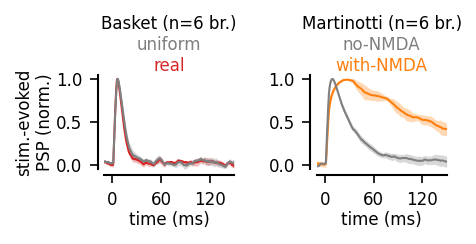

In [17]:
fig, AX = pt.figure(axes=(2, 1), figsize=(1,1), wspace=1)

for c, cell, iBranch, VMS, labels, colors in zip(range(2),
                                 ['Basket', 'Martinotti'],
                                 [1, 1],
                                 [VMsPassiveBasket, VMsPassiveMartinotti],
                                 [['real', 'uniform'], ['with-NMDA', 'no-NMDA']],
                                 [['tab:red', 'tab:grey'], ['tab:orange', 'tab:grey']]):

    pt.annotate(AX[c], cell+' (n=6 br.)'+'\n'*2, (0.5, 1), ha='center', va='bottom', color='k')
    for l, label, color in zip(range(2), labels, colors):
        pt.annotate(AX[c], label+'\n'*l, (0.5, 1), ha='center', va='bottom',color=color)
        pre_cond = (T<0)
        NormVm = []
        for i in range(VMS[label].shape[0]):
            peak = np.max(VMS[label][i,:,:,:].mean(axis=(0,1)))
            baseline = np.mean(VMS[label][i,:,:,:].mean(axis=(0,1))[pre_cond])
            NormVm.append((VMS[label][i,:,:,:].mean(axis=(0,1))-baseline)/(peak-baseline))
        pt.plot(T, np.mean(NormVm, axis=0), np.std(NormVm, axis=0), color=color, ax=AX[c])
for ax in AX:
    pt.set_plot(ax, yticks=[0,0.5,1], ylim=[-0.05,1.05],
                xlim=[-10,150] if ax==AX[0] else [-10,150],
                xlabel='time (ms)', 
                ylabel='stim.-evoked\nPSP (norm.)' if ax==AX[0] else '')
fig.savefig('../../figures/detailed_model/timing-props-norm-psp-sem-long.eps')
fig.savefig('../../figures/detailed_model/timing-props-norm-psp-sem-long.svg')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


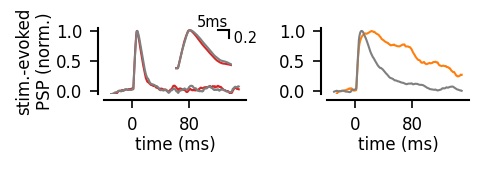

In [18]:
fig, AX = pt.figure(axes=(2,1),
                    figsize=(1.05,.7), hspace=0.2, wspace=0.9)

for c, cell, iBranch, VMS, labels, colors in zip(range(2),
                                 ['Basket', 'Martinotti'],
                                 [1, 1],
                                 [VMsPassiveBasket, VMsPassiveMartinotti],
                                 [['real', 'uniform'], ['with-NMDA', 'no-NMDA']],
                                 [['tab:red', 'tab:grey'], ['tab:orange', 'tab:grey']]):

    if cell=='Basket':
        inset = pt.inset(AX[c], (0.5, 0.3, 0.4, 0.7))
    for l, label, color in zip(range(2), labels, colors):
        pre_cond = (T<0)
        peak = np.max(VMS[label][iBranch,:,:,:].mean(axis=(0,1)))
        baseline = np.mean(VMS[label][iBranch,:,:,:].mean(axis=(0,1))[pre_cond])
        NormVm = (VMS[label][iBranch,:,:,:].mean(axis=(0,1))-baseline)/(peak-baseline)
        pt.plot(T, NormVm, color=color, ax=AX[c])
        if cell=='Basket':
            pt.plot(T, NormVm, color=color, ax=inset)
inset.axis('off')
pt.set_plot(inset, xlim=[-.1,25])
pt.draw_bar_scales(inset, Xbar=5, Xbar_label='5ms',
                   Ybar=0.2, Ybar_label=' 0.2', 
                   fontsize=7, loc='top-right')
for ax in AX:
    pt.set_plot(ax, yticks=[0,0.5,1], ylim=[-0.05,1.05],
                #xlim=[-10,100] if ax==AX[0] else [-10,150],
                xlabel='time (ms)', 
                ylabel='stim.-evoked\nPSP (norm.)' if ax==AX[0] else '')
fig.savefig('../../figures/detailed_model/timing-props-norm-psp-long.eps')
fig.savefig('../../figures/detailed_model/timing-props-norm-psp-long.svg')

## Stimulus-Evoked Firing Dynamics

Many repetitions for the stimulus, run with:
```
# Basket Cell
python stim_on_background.py -c Basket --nCluster 35 --bgStimFreq 2e-3 --bgFreqInhFactor 1 --nStimRepeat 30 --test_uniform --suffix TimeCourse --ISI 300
# Martinotti Cell
python stim_on_background.py -c Martinotti --nCluster 35 --bgStimFreq 5e-4 --bgFreqInhFactor 1 --nStimRepeat 30 --test_NMDA --suffix TimeCourse --ISI 300
```

In [48]:
# load the two simulation data
n=50
simBasket = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simTimeCourse%i_Basket.zip' % n)
simBasket.load()
T, VMsBasket, SpikesBasket, RATEsBasket = extract_trials(simBasket,
                                    loc='soma',
                                    varied_key = 'from_uniform',
                                    true_false_labels=['uniform', 'real'])
n=50
simMartinotti = Parallel(\
        filename='../../data/detailed_model/StimOnBg_simTimeCourse%i_Martinotti.zip' % n)
simMartinotti.load()
T, VMsMartinotti, SpikesMartinotti, RATEsMartinotti = extract_trials(simMartinotti,
                              loc='soma',
                              varied_key = 'with_NMDA',
                              true_false_labels=['with-NMDA', 'no-NMDA'])
dt = simBasket.fetch_quantity_on_grid('dt', return_last=True)

In [72]:
np.sum(SpikesMartinotti['no-NMDA'][0,0,10,-10:]),np.sum(SpikesMartinotti['no-NMDA'][5,0,10,:])

(0, 1)

### Branch-Averaged Data

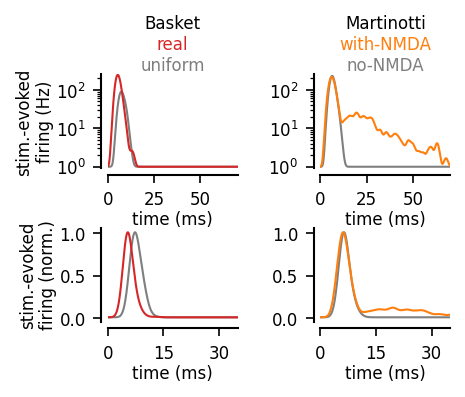

In [49]:
from scipy.ndimage import gaussian_filter1d

smoothing = 1 # ms
bottom = 1 # Hz in log plots

fig, AX = pt.figure(axes=(2, 2), figsize=(1,1))
# Basket
pt.annotate(AX[0][0], 'Basket'+'\n'*2, (0.5, 1), ha='center', va='bottom',color='k')
for l, label, color in zip(range(2),
                           ['uniform', 'real'],
                           ['tab:grey', 'tab:red']):
    pt.annotate(AX[0][0], label+'\n'*l, (0.5, 1), ha='center', va='bottom',color=color)
    smoothed = gaussian_filter1d(RATEsBasket[label].mean(axis=(0,1,2)),
                                 int(smoothing/dt))+bottom
    peak = np.max(smoothed)
    pre_cond = (T<0)
    baseline = np.mean(smoothed[pre_cond])
    Norm = (smoothed-baseline)/(peak-baseline)+1e-2
    pt.plot(T, Norm, color=color, ax=AX[1][0])
    pt.plot(T, smoothed, color=color, ax=AX[0][0])
# Martinotti
pt.annotate(AX[0][1], 'Martinotti'+'\n'*2, (0.5, 1), ha='center', va='bottom',color='k')
for l, label, color in zip(range(2),
                           ['no-NMDA', 'with-NMDA'],
                           ['tab:grey', 'tab:orange']):
    pt.annotate(AX[0][1], label+'\n'*l, (0.5, 1), ha='center', va='bottom',color=color)
    smoothed = gaussian_filter1d(RATEsMartinotti[label].mean(axis=(0,1,2)),
                                 int(smoothing/dt))+bottom
    peak = np.max(smoothed)
    pre_cond = (T<0)
    baseline = np.mean(smoothed[pre_cond])
    Norm = (smoothed-baseline)/(peak-baseline)+1e-2
    pt.plot(T, Norm, color=color, ax=AX[1][1])
    pt.plot(T, smoothed, color=color, ax=AX[0][1])
for ax in AX[0]:
    pt.set_plot(ax, yscale='log', xlim=[0,70],
                ylim=[.9*bottom, ax.get_ylim()[1]],
               xlabel='time (ms)', 
                ylabel='stim.-evoked\nfiring (Hz)' if ax==AX[0][0] else '')
for ax in AX[1]:
    pt.set_plot(ax, xlim=[0,35], yticks=[0, 0.5, 1],
               xlabel='time (ms)', 
                ylabel='stim.-evoked\nfiring (norm.)' if ax==AX[1][0] else '')
pt.set_common_ylims(AX[0])

### Single Branch Example

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


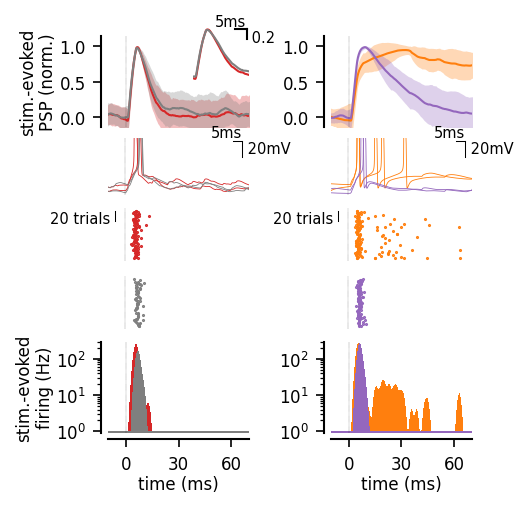

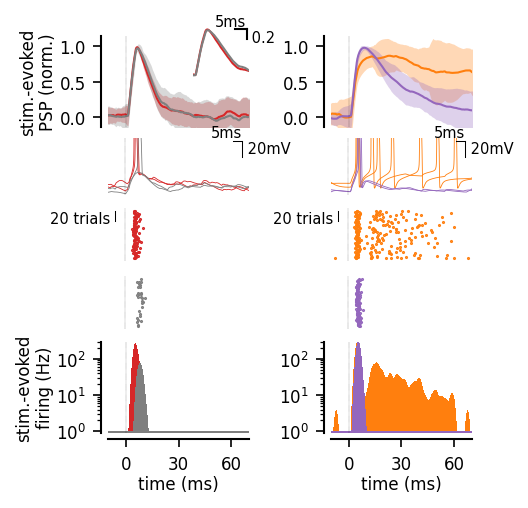

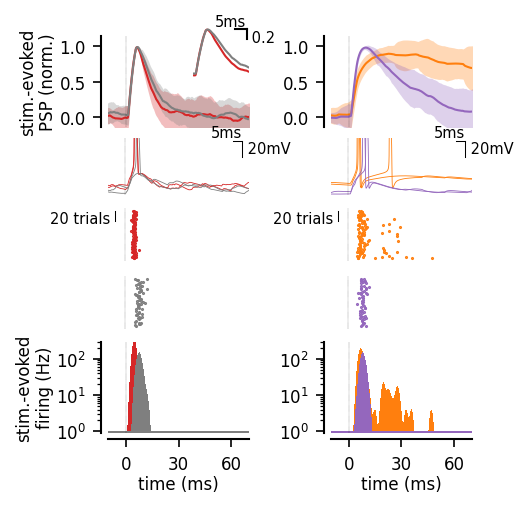

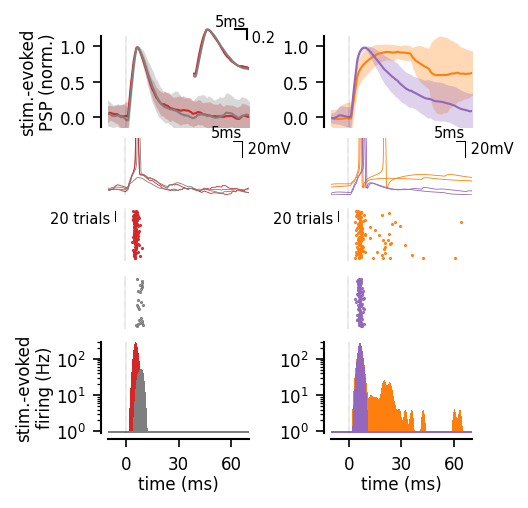

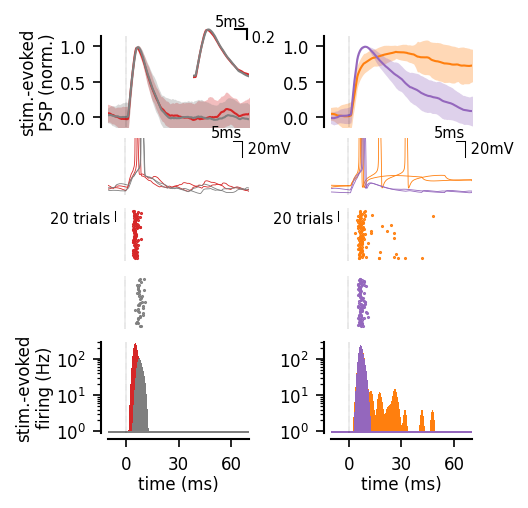

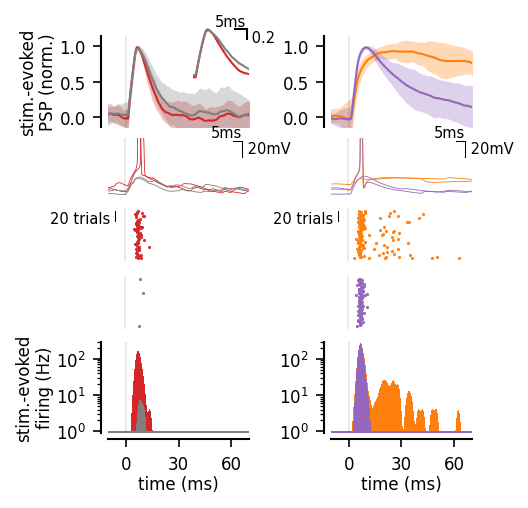

In [75]:
smoothing = 1 # ms
bottom = 1 # Hz

for iBranch in range(6):

    fig, AX = pt.figure(axes_extents=[[(1,3), (1,3)],
                                      [(1,2), (1,2)],
                                      [(1,2), (1,2)],
                                      [(1,2), (1,2)],
                                      [(1,3), (1,3)]],                                 
                        figsize=(1.05,.25), hspace=0.7, wspace=0.9)
    
    pt.set_common_xlims(AX, lims=[-10,70])

    for c, cell, iBranch, VmEx, VMSpassive,\
            RATES, VMS, SPIKES, labels, colors in zip(range(2),
                                     ['Basket', 'Martinotti'],
                                     [iBranch, iBranch],
                                     [[0,1], [1,4]],
                                     [VMsPassiveBasket, VMsPassiveMartinotti],
                                     [RATEsBasket, RATEsMartinotti],
                                     [VMsBasket, VMsMartinotti],
                                     [SpikesBasket, SpikesMartinotti],
                                     [['real', 'uniform'], ['with-NMDA', 'no-NMDA']],
                                     [['tab:red', 'tab:grey'], ['tab:orange', 'tab:purple']]):
        # VMS subthreshold
        if cell=='Basket':
            inset = pt.inset(AX[0][c], (0.6, 0.5, 0.4, 0.6))
        for l, label, color in zip(range(2), labels, colors):
            pre_cond = (T<0)
            peaks = np.max(VMSpassive[label][iBranch,0,:,:], axis=-1)
            baselines = [np.mean(VMSpassive[label][iBranch,0,t,:][pre_cond])\
                                 for t in range(VMSpassive[label].shape[2])]
            NormVm = [(VMSpassive[label][iBranch,0,t,:]-baselines[t])/(peaks[t]-baselines[t])\
                                 for t in range(VMSpassive[label].shape[2])]
            pt.plot(T, np.mean(NormVm, axis=0), sy=np.std(NormVm, axis=0),
                    color=color, ax=AX[0][c])
            if cell=='Basket':
                pt.plot(T, np.mean(NormVm, axis=0), color=color, ax=inset)
        if cell=='Basket':
            inset.axis('off')
            pt.set_plot(inset, xlim=[-.1,25])
            pt.draw_bar_scales(inset, Xbar=5, Xbar_label='5ms',
                               Ybar=0.2, Ybar_label=' 0.2', 
                               fontsize=7, loc='top-right')
        pt.set_plot(AX[0][c], ['left'], ylim=[-0.15,1.15], yticks=[0, 0.5, 1],
                    ylabel='stim.-evoked\nPSP (norm.)' if c==0 else '')

        # VMS
        for l, label, color in zip(range(2), labels, colors):
            for ex in VmEx:
                AX[1][c].plot(T, VMS[label][iBranch,0,ex,:], color=color, lw=0.4)
            AX[1][c].axis('off')
        AX[1][c].set_ylim([-70,0])
        pt.draw_bar_scales(AX[1][c], Ybar=20, Ybar_label=' 20mV', 
                           Xbar=5, Xbar_label='5ms', fontsize=7, lw=0.5, loc='top-right')
        # SPIKES
        for l, label, color in zip(range(2), labels, colors):
            for trial in range(SPIKES[label].shape[2]):
                spikes = T[SPIKES[label][iBranch,0,trial,:]==1]
                AX[2+l][c].plot(spikes, trial*np.ones(len(spikes)), '.', color=color, ms=1)
        pt.draw_bar_scales(AX[2][c], Ybar=20, Ybar_label='20 trials ', Xbar=1e-12, fontsize=7, lw=0.5)
        # RATES
        for label, color in zip(labels, colors):
            smoothed = np.clip(gaussian_filter1d(RATES[label][iBranch,0,:,:].mean(axis=0),
                               int(smoothing/dt)), bottom, np.inf)
            AX[4][c].bar(T, smoothed, color=color, width=T[1]-T[0])#, bottom=.9*bottom)
        pt.set_plot(AX[4][c], yscale='log', ylim=[.9*bottom, 300],
                    xlabel='time (ms)', ylabel='stim.-evoked\nfiring (Hz)' if c==0 else '')


    for ax in pt.flatten(AX):
        ax.plot([0,0], ax.get_ylim(), 'k:', lw=0.2)
    for ax in pt.flatten(AX[1:4]):
        ax.axis('off')

    fig.savefig('../../figures/detailed_model/timing-props-Full-branch-%i.eps' % (iBranch+1))
    fig.savefig('../../figures/detailed_model/timing-props-Full-branch-%i.svg' % (iBranch+1))

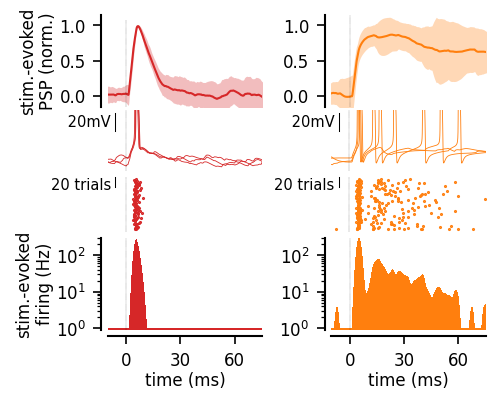

In [56]:
fig, AX = pt.figure(axes_extents=[[(1,3), (1,3)],
                                  [(1,2), (1,2)],
                                  [(1,2), (1,2)],
                                  [(1,3), (1,3)]],                                 
                    figsize=(1.1,.3), hspace=0.2, wspace=0.7)

smoothing = 1 # ms
bottom = 1 # Hz
iBranch = 5

for c, cell, iBranch, VmEx, VMSpassive,\
        RATES, VMS, SPIKES, label, color in zip(range(2),
                                 ['Basket', 'Martinotti'],
                                 [iBranch, iBranch],
                                 [[0,1,2], [1,4,17]],
                                 [VMsPassiveBasket, VMsPassiveMartinotti],
                                 [RATEsBasket, RATEsMartinotti],
                                 [VMsBasket, VMsMartinotti],
                                 [SpikesBasket, SpikesMartinotti],
                                 ['real', 'with-NMDA'],
                                 ['tab:red', 'tab:orange']):
    # VMS subthreshold
    pre_cond = (T<0)
    peaks = np.max(VMSpassive[label][iBranch,0,:,:], axis=-1)
    baselines = [np.mean(VMSpassive[label][iBranch,0,t,:][pre_cond])\
                         for t in range(VMSpassive[label].shape[2])]
    NormVm = [(VMSpassive[label][iBranch,0,t,:]-baselines[t])/(peaks[t]-baselines[t])\
                         for t in range(VMSpassive[label].shape[2])]
    pt.plot(T, np.mean(NormVm, axis=0), sy=np.std(NormVm, axis=0),
            color=color, ax=AX[0][c])
    # VMS
    for ex in VmEx:
        AX[1][c].plot(T, VMS[label][iBranch,0,ex,:], color=color, lw=0.4)
    AX[1][c].axis('off')
    pt.set_common_ylims(AX[1], lims=[-70,0])
    # SPIKES
    for trial in range(SPIKES[label].shape[2]):
        spikes = T[SPIKES[label][iBranch,0,trial,:]==1]
        AX[2][c].plot(spikes, trial*np.ones(len(spikes)), '.', color=color, ms=1)
    # RATES
    smoothed = np.clip(gaussian_filter1d(RATES[label][iBranch,0,:,:].mean(axis=0),
                       int(smoothing/dt)), bottom, np.inf)
    AX[3][c].bar(T, smoothed, color=color, width=T[1]-T[0])#, bottom=.9*bottom)
pt.set_common_xlims(AX, lims=[-10,75])
for ax in pt.flatten(AX):
    ax.plot([0,0], ax.get_ylim(), 'k:', lw=0.2)
for ax in AX[0]:
    pt.set_plot(ax, ['left'], ylim=[-0.15,1.15], yticks=[0, 0.5, 1],
                ylabel='stim.-evoked\nPSP (norm.)' if ax==AX[0][0] else '')
for ax in AX[1]:
    ax.axis('off')
    pt.draw_bar_scales(ax, Ybar=20, Ybar_label=' 20mV ', Xbar=1e-12, fontsize=7, lw=0.5, loc='top-left')
for ax in AX[2]:
    ax.axis('off')
    pt.draw_bar_scales(ax, Ybar=20, Ybar_label='20 trials ', Xbar=1e-12, fontsize=7, lw=0.5)
for ax in AX[3]:
    pt.set_plot(ax, yscale='log', ylim=[.9*bottom, 300],
                xlabel='time (ms)',
                ylabel='stim.-evoked\nfiring (Hz)' if ax==AX[3][0] else '')
#fig.savefig('../../figures/detailed_model/timing-props-Basket-vs-Martinotti.eps')
#fig.savefig('../../figures/detailed_model/timing-props-Basket-vs-Martinotti.svg')

## Summary Quantities

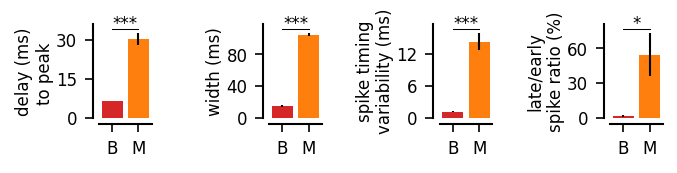

In [85]:
fig, AX = pt.figure(axes=(4,1), figsize=(.5,1), wspace=3.5)

with_points = False

from scipy.stats import wilcoxon, ttest_ind, skew
def add_stats(X, ax, test=ttest_ind):
    ylim = ax.get_ylim()[1]
    ax.plot([0,1], np.ones(2)*ylim, 'k-', lw=0.5)
    ax.annotate(pt.from_pval_to_star(test(*X).pvalue), (0.5, ylim), ha='center')
   
pre_cond = (T<0)
LE_threshold = 10 # late early threshold

## SUBTHRESHOLD DYNAMICS
PEAKS, INTEGRALS = [], []
for c, VMSpassive, label, color in zip(range(2),  [VMsPassiveBasket, VMsPassiveMartinotti],
                                 ['real', 'with-NMDA'], ['tab:red', 'tab:orange']):
    # -- compute normalized PSP
    peaks = [np.max(VMSpassive[label][iBranch,0,:,:].mean(axis=0), axis=-1) for iBranch in range(6)]
    baselines = [np.mean(VMSpassive[label][iBranch,0,:,:].mean(axis=0)[pre_cond]) for iBranch in range(6)]
    NormVm = [(VMSpassive[label][iBranch,0,:,:].mean(axis=0)-\
               baselines[iBranch])/(peaks[iBranch]-baselines[iBranch]) for iBranch in range(6)]
    # -- delay to peak PSP
    PEAKS.append([T[np.argmax(NormVm[iBranch])] for iBranch in range(6)])
    AX[0].bar([c], [np.mean(PEAKS[-1])], yerr=[sem(PEAKS[-1])], color=color)
    # -- width as integral of the normalized PSP
    INTEGRALS.append([np.trapz(NormVm[iBranch], T) for iBranch in range(6)])
    AX[1].bar([c], [np.mean(INTEGRALS[-1])], yerr=[sem(INTEGRALS[-1])], color=color)
    
# -- stats
add_stats(PEAKS, AX[0])
add_stats(INTEGRALS, AX[1])

## FIRING DYNAMICS
# -- delay to spike
MEANS, VARS, SKEWS, LE_RATIOS = [], [], [], []
for c, SPIKEs, label, color in zip(range(2), [SpikesBasket, SpikesMartinotti],
                                 ['real', 'with-NMDA'], ['tab:red', 'tab:orange']):
    # SPIKES
    SPIKES = [ np.concatenate([T[SPIKEs[label][iBranch,0,t,:]==1]\
                               for t in range(SPIKEs[label].shape[2])])\
                                  for iBranch in range(6)]
    MEANS.append([spikes[spikes>0].mean() for spikes in SPIKES])
    VARS.append([spikes[spikes>0].std() for spikes in SPIKES])
    SKEWS.append([skew(spikes[spikes>0]) for spikes in SPIKES])
    AX[2].bar([c], [np.mean(VARS[-1])], yerr=[sem(VARS[-1])], color=color)
    LE_RATIOS.append([100*np.sum(spikes>LE_threshold)/np.sum((spikes>0) & (spikes<LE_threshold))\
                     for spikes in SPIKES])
    AX[3].bar([c], [np.mean(LE_RATIOS[-1])], yerr=[sem(LE_RATIOS[-1])], color=color)
    if with_points:
        AX[3].plot(c+np.linspace(-0.1,0.1,6), LE_RATIOS[-1], 'o', color=color)
        
add_stats(VARS, AX[2])
add_stats(LE_RATIOS, AX[3])

pt.set_plot(AX[0], xticks=[0,1], xticks_labels=['B', 'M'],
            ylabel='delay (ms)\nto peak ')
pt.set_plot(AX[1], xticks=[0,1], xticks_labels=['B', 'M'],
            ylabel='width (ms)')
pt.set_plot(AX[2], xticks=[0,1], xticks_labels=['B', 'M'],
            ylabel='spike timing\nvariability (ms)')
pt.set_plot(AX[3], xticks=[0,1], xticks_labels=['B', 'M'],
            ylabel='late/early\nspike ratio (%)')

fig.savefig('../../figures/detailed_model/temporal_props_comp_summary.svg')